In [8]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math

%matplotlib inline

def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    #return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold=70, high_threshold=150):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size=5):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices=None):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    if vertices is None:
        imshape = img.shape
        vertices = np.array([[(150, imshape[0]), (450,320), (510,320), (imshape[1], imshape[0])]], dtype=np.int32)
        
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
            
    left_slopes = list()
    right_slopes = list()
    
    max_y = 0

    start_l_pos = [0, img.shape[1]]
    start_r_pos = [0, img.shape[1]]

    for line in lines:

        for x1,y1,x2,y2 in line:
            
            m = (x2-x1)/(y2-y1)
            if m > 2. or m < -2. or math.isnan(m):
                #print("Extreme slope:", m, "pos:", line)
                continue

            if max_y < y1: max_y = y1
            if max_y < y2: max_y = y2
                
            if x1 < 490 and x2 < 490:
                
                left_slopes.append(m)
                #print("LL slope:", m, "pos:", line)
                    
                if start_l_pos[1] > y1:
                    start_l_pos = (x1, y1)
                if start_l_pos[1] > y2:
                    start_l_pos = (x2, y2)

            else:
                right_slopes.append(m)
                #print("RL slope:", m, "pos:", line)
                
                if start_r_pos[1] > y1:
                    start_r_pos = (x1,y1)
                if start_r_pos[1] > y2:
                    start_r_pos = (x2,y2)
            
    left_avg_slope = np.mean(left_slopes)
    if (math.isnan(left_avg_slope)): 
        print("Left slope avg is NAN")
        return None
    
    right_avg_slope = np.mean(right_slopes)
    
    left_x = int(left_avg_slope * (max_y - start_l_pos[1]) + start_l_pos[0])
    right_x = int(right_avg_slope * (max_y - start_r_pos[1]) + start_r_pos[0])

    #print("Start Left", start_l_pos, ", avg slope:", left_avg_slope)
    #print("Start Right", start_r_pos, ", avg slope:", right_avg_slope)

    cv2.line(img, start_l_pos, (left_x, max_y), color, thickness)
    cv2.line(img, start_r_pos, (right_x, max_y), color, thickness)
    

def hough_lines(canny_img, rho=1, theta=np.pi/180, threshold=15, min_line_len=6, max_line_gap=4):
    """
    `canny_img` should be the output of a Canny transform.
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(canny_img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((canny_img.shape[0], canny_img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(hough_img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, hough_img, β, λ)


def process_image(image):
    
    img_gray = grayscale(image)
    img_gauss = gaussian_blur(img_gray)
    img_canny = canny(img_gauss)
    
    img_canny_masked = region_of_interest(img_canny)    
    img_hough = hough_lines(img_canny_masked)
    img_rend = weighted_img(image, img_hough)
    return img_rend

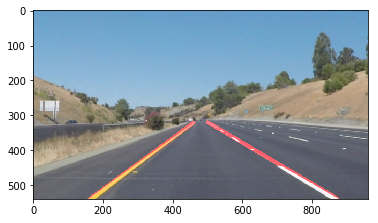

In [9]:
import os
filename = os.listdir('test_images/')
initial_img = mpimg.imread('test_images/' + filename[5])
result_img = process_image(initial_img)
plt.imshow(result_img)